# Binary classification of dog and cat images

This notebook works through creating a convolutional neural network using Keras for binary classification of dog and cat images. The images used are a portion of Kaggle's dataset in [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) competition. We use 2000 images for training, 1000 for validation and 1000 for testing. All three sets have equal number of dog and cat images. Images are of different dimensions.

There are two parts in the notebook. The first one is about creating a simple ConvNet, and applying it to our small dataset, resulting in ~70% accuracy. The second part is improving the first model by adding image augmentation as a way to fight overfitting. This model will result in higher accuracy of ~80%.

In [3]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [16]:
# Change these for your case
TRAIN_DIR = 'C:/Users/mp3213/Desktop/Projects/Playfield/data/DogsCatsData/train/'
VALIDATION_DIR = 'C:/Users/mp3213/Desktop/Projects/Playfield/data/DogsCatsData/validation/'

In [8]:
def create_simple_model(dropout_rate=0):
    """
    This method creates, compiles and returns a simple ConvNet without using data augmentation.
    """
    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Flatten())
    model.add(layers.Dropout(rate=dropout_rate))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    print(model.summary())
    
    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.rmsprop(lr=1e-4),
              metrics=['acc'])
    
    return model

Keras offers a few methods and classes to help with loading image data from file and process them before fed to a neural network. Here, we'll use the  `ImageDataGenerator` class to process batches of images: scale image dimensions, normalize pixel values and assign binary class to images. Images are automatically taken from a passed directory, processed and generated using a Python generator object. 

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Since images come from the above generators, we'll use the `fit_generator` method of Keras to train our model. This method is analog to the usually used `fit` method. Since we take batches of 20 images, we then set the `steps_per_epoch` to 100, so we get all 2000 training images in an epoch. The validation steps also have a finite value of 50, to limit the validation generator.

In [18]:
model = create_simple_model(dropout_rate=0)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

model.save('simple_dogs_cats_convnet.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

It would be useful to look at the loss and accuracy values over different epochs. The following method plots both.

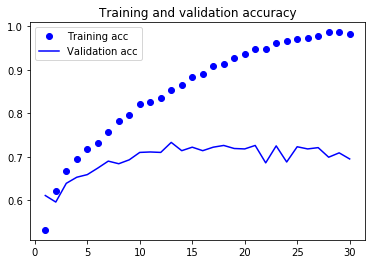

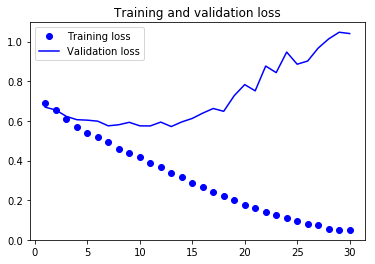

In [43]:
def plot_loss_acc(history_object):
    """
    Plots two figures of the loss function and the accuracy metric. 
    The input argument takes a history object, which is returned in the model fitting step.
    """
    acc = history_object.history['acc']
    val_acc = history_object.history['val_acc']
    loss = history_object.history['loss']
    val_loss = history_object.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()
    
plot_loss_acc(history)

Ok now, let's do a few changes to add image augmentation in the process and improve the results. First, let's define what changes to an image are allowed within a `ImageDataGenerator` object. Augmentation will only be used in the training step, so we won't do any changes to the test generator.

In [20]:
train_datagen_augm = ImageDataGenerator(
    rotation_range=40,
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

Now we'll need a new generator drawing data from the above ImageDataGenerator.

In [21]:
train_generator_augm = train_datagen_augm.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator_augm = test_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The following method can be used to view a few augmented images of a random cat image.

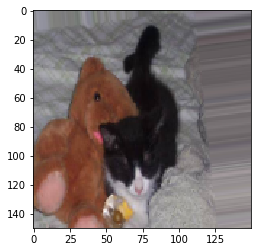

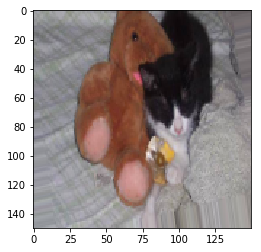

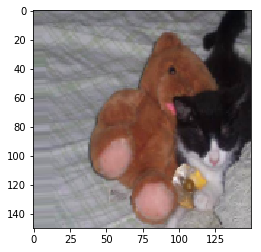

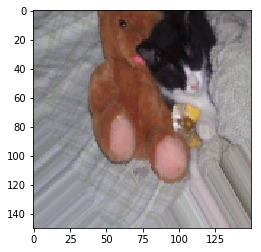

In [22]:
def plot_augmented_pics():
    """
    Plots 4 augmented figures of a random cat picture.
    :return: /
    """
    
    # An image generator used for the visualization only
    datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

    # Pick a random image from file and load it as numpy array 
    filenames = [os.path.join(TRAIN_DIR + '/cats', fname) for fname in os.listdir(TRAIN_DIR + '/cats')]
    import numpy as np
    rand_index = np.random.randint(0, len(filenames))
    img = image.load_img(filenames[rand_index], target_size=(150, 150))  # reads the image
    x = image.img_to_array(img)  # convert to numpy array
    x = x.reshape((1,) + x.shape)  # reshpe to (1, 150, 150, 3)

    # Plot 4 augmented images
    i = 0
    for batch in datagen.flow(x, batch_size=1):
        plt.figure(i)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 4 == 0:
            break

    plt.show()

plot_augmented_pics()

In [ ]:
# Create a new model, and also add Dropout to completely eliminate overfitting
model_augm = create_simple_model(dropout_rate=0.5)

# Fit the new model to data
history_augm = model.fit_generator(
    train_generator_augm,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator_augm,
    validation_steps=50
)

# Save model to file
model.save('convnet_augm_dogs_cats.h5')

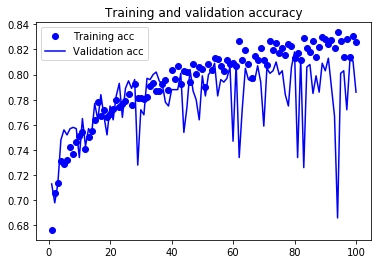

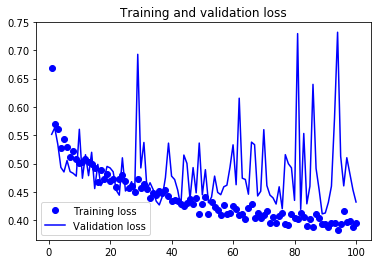

In [42]:
# Visualize the loss and accuracy metrics
plot_loss_acc(history_augm)

The last figures of the model using augmentation show improvement compared to the previous model without augmentation: reacgubg accuracy of around 80%, compared to the previous 70%. We can observe a bigger variance in Validation loss and accuracy towards the higher epoch runs. This is proabably due to the dropout of 0.5, which means that we're only taking 50% of the nodes' outputs at one of the flattened layers. 

By playing with the dropout rate, adding it to the other layers, and playing with the augmentation we could probably improve the model performance by a few percent. Anyway to reach an accuracy of over 90% we would need much bigger data than the 2000 training and 1000 validation images. 

## References
- "Deep Learning with Python" book by Francois Chollet